In [7]:
import os


os.environ["SPARK_HOME"] = "/Users/deyangcao/github-classroom/met-ad-688/lab08-deyang1112/.venv/lib/python3.13/site-packages/pyspark"
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17"


Load the Dataset

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LightcastModel").getOrCreate()

lightcast = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("lightcast_job_postings.csv")


lightcast.printSchema()
lightcast.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/21 15:13:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: date (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: date (nullable = true)
 |-- EXPIRED: date (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: date (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (nullable

25/04/21 15:13:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+---

# Feature Engineering

In [10]:
[col for col in lightcast.columns if "SALARY" in col.upper() or "COMPENSATION" in col.upper() or "WAGE" in col.upper()]


['SALARY', 'SALARY_TO', 'SALARY_FROM']

3 Train/Test Split
Perform a random split of the data into training and testing sets.
Set a random seed for reproducibility.
You can choose a number for splitting to your liking, justify your choice.

In [19]:
train_data, test_data = data.randomSplit([0.82, 0.18], seed=42)

print("Train count:", train_data.count())
print("Test count:", test_data.count())



25/04/21 15:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1918.9 KiB
25/04/21 15:55:45 WARN DAGScheduler: Broadcasting large task binary with size 1918.9 KiB


Train count: 18010


Test count: 3885


I randomly split the dataset into training and testing sets using an 82% / 18% ratio with a fixed random seed for reproducibility. This resulted in 18,010 training records and 3,885 testing records, providing sufficient data to train the model while retaining a robust set for evaluation.

Task4. Train & Evaluate Linear Regression


In [46]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)
summary = lr_model.summary


print("Intercept:", lr_model.intercept)
print("Coefficients:", lr_model.coefficients.toArray().tolist()[:5])  # 只打印前5项
print("R²:", summary.r2)
print("RMSE:", summary.rootMeanSquaredError)
print("MAE:", summary.meanAbsoluteError)




25/04/21 16:27:54 WARN Instrumentation: [096f1ce0] regParam is zero, which might cause numerical instability and overfitting.


Intercept: 147404.44136814837
Coefficients: [-35466.45855326216, -33281.272817048506, -12517.026398356225, 32281.251323275446, 16370.633804286244]
R²: 0.7403202087328479
RMSE: 20255.346244425873
MAE: 12390.53182172691


In [48]:
# Estimate = coefficients + intercept
print("Estimate length:", len(lr_model.coefficients))  # 不含 intercept

# summary 自带完整的 5 个（包括 intercept）
print("Std Error length:", len(summary.coefficientStandardErrors))
print("t-Value length:", len(summary.tValues))
print("P-Value length:", len(summary.pValues))

# 打印前几项具体数值（用最简单的print）
print("\nEstimates:", lr_model.coefficients.toArray().tolist() + [lr_model.intercept])
print("Std Errors:", summary.coefficientStandardErrors)
print("t-Values:", summary.tValues)
print("P-Values:", summary.pValues)



Estimate length: 69
Std Error length: 70
t-Value length: 70
P-Value length: 70

Estimates: [-35466.45855326216, -33281.272817048506, -12517.026398356225, 32281.251323275446, 16370.633804286244, 33307.483754506626, 81521.61503439429, -50944.723816826365, -54736.721496934784, -650.0277086005476, -8379.324074560398, -30820.834825286558, -10210.385494159884, -35569.67964427866, 30562.907960458942, 22425.75480782827, 16115.190867117468, 45597.454113745145, 16726.142105694038, 48477.11227145831, 48498.80568750289, 10066.501703855987, 7708.264635914309, -16521.529744744686, 19843.694863123488, 9458.653277867988, 4390.2289301663595, 48478.2666474193, -10430.942492038728, -10313.068408687903, 22592.4942779536, -22296.17305771141, 4663.968485858527, -32528.104329345173, -52992.281744892556, 94710.22377803148, 38594.32166378726, -15508.924178832902, -29913.696601735268, 920.6130346607144, -64390.25129681596, 21644.342789832754, 3625.100656906428, 43900.535339292735, -13771.326797498115, 46027.201

In [ ]:
import pandas as pd

# Combine intercept and coefficients
estimates = [lr_model.intercept] + list(lr_model.coefficients)


coefs_df = pd.DataFrame({
    "Estimate": estimates,
    "Std Error": summary.coefficientStandardErrors,
    "t-Value": summary.tValues,
    "P-Value": summary.pValues
})


coefs_df.index = ["Intercept"] + [f"Feature {i}" for i in range(len(lr_model.coefficients))]
coefs_df.reset_index(inplace=True)
coefs_df.rename(columns={"index": "Feature"}, inplace=True)

coefs_df


,Feature,Estimate,Std Error,t-Value,P-Value
0,Intercept,147404.441368,3360.326427,-10.554468,0.000000e+00
1,Feature 0,-35466.458553,3664.527580,-9.082009,0.000000e+00
2,Feature 1,-33281.272817,3723.504884,-3.361625,7.829000e-04
3,Feature 2,-12517.026398,3702.296632,8.719250,0.000000e+00
4,Feature 3,32281.251323,4093.020880,3.999646,6.470609e-05
...,...,...,...,...,...
65,Feature 64,-21353.643134,28984.474748,-1.362706,1.730602e-01
66,Feature 65,-39497.305357,25119.973878,-1.356071,1.751612e-01
67,Feature 66,-34064.472341,28990.002719,-0.845888,3.976709e-01
68,Feature 67,-24522.309166,31.307099,0.244866,8.065744e-01


A linear regression model was trained to predict SALARY based on 69 engineered features. The model yielded an intercept of approximately 147,404.44. The model's performance on the training data indicated an R² value of approximately 0.26, meaning it explains about 26% of the variance in salaries. Additionally, the RMSE and MAE were around 36,600 and 28,100, respectively, suggesting a moderate level of prediction error.

Several features were found to be statistically significant. For instance, Feature 0 and Feature 1 had large negative coefficients (around -35,466 and -33,281 respectively) and very small p-values, indicating a strong and reliable negative association with salary. Feature 2 and Feature 3 also showed significant effects, with t-values greater than |3| and p-values well below 0.001, contributing positively and negatively, respectively. Notably, Feature 68, although small in magnitude (7.67), had an extremely low p-value (1.67e-12), highlighting its statistical significance.

On the other hand, a number of features—particularly from Feature 64 to Feature 67—showed high p-values (> 0.1), suggesting that their effects may not be statistically meaningful and could be candidates for exclusion in a refined model. Overall, the model demonstrates a foundational ability to explain salary variance, though improvements such as feature selection or regularization could enhance predictive accuracy and generalizability.

 Section 4.1：Generalized Linear Regression Summary

In [34]:
# Step 1: 筛选前 50 个高频职位
from pyspark.sql.functions import col

top_titles_df = df.groupBy("TITLE_RAW").count().orderBy(col("count").desc()).limit(50)
top_titles = [row["TITLE_RAW"] for row in top_titles_df.collect()]
df_filtered = df.filter(col("TITLE_RAW").isin(top_titles))

# Step 2: 特征工程（StringIndexer + OneHot + Assembler）
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df_filtered = df_filtered.dropna(subset=["SALARY", "TITLE_RAW", "EDUCATION_LEVELS_NAME", "MODELED_DURATION"])
categorical_cols = ["TITLE_RAW", "EDUCATION_LEVELS_NAME"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=[f"{col}_vec" for col in categorical_cols] + ["MODELED_DURATION"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df_filtered).transform(df_filtered)

# Step 3: Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Step 4: Generalized Linear Regression
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(featuresCol="features", labelCol="SALARY")
model = glr.fit(train_data)
summary = model.summary




25/04/21 16:11:04 WARN Instrumentation: [0cbed58f] regParam is zero, which might cause numerical instability and overfitting.


In [ ]:
print(f"Length of features: {len(features)}")
print(f"Length of coefs: {len(coefs)}")
print(f"Length of se: {len(se)}")
print(f"Length of tvals: {len(tvals)}")
print(f"Length of pvals: {len(pvals)}")



Length of features: 3
Length of coefs: 69
Length of se: 70
Length of tvals: 70
Length of pvals: 70


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


In [ ]:
predictions = lr_model.transform(test_data)

from pyspark.sql import functions as F


predictions_with_residuals = predictions.withColumn("Residual", F.col("SALARY") - F.col("prediction"))


predictions_df = predictions_with_residuals.select("SALARY", "prediction", "Residual").toPandas()
predictions_df.columns = ["Actual", "Predicted", "Residual"]

predictions_df.head()


,Actual,Predicted,Residual
0,109200,95583.744165,13616.255835
1,82450,93206.121765,-10756.121765
2,130500,130472.434907,27.565093
3,95000,84908.810522,10091.189478
4,67642,85276.780053,-17634.780053


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 41.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


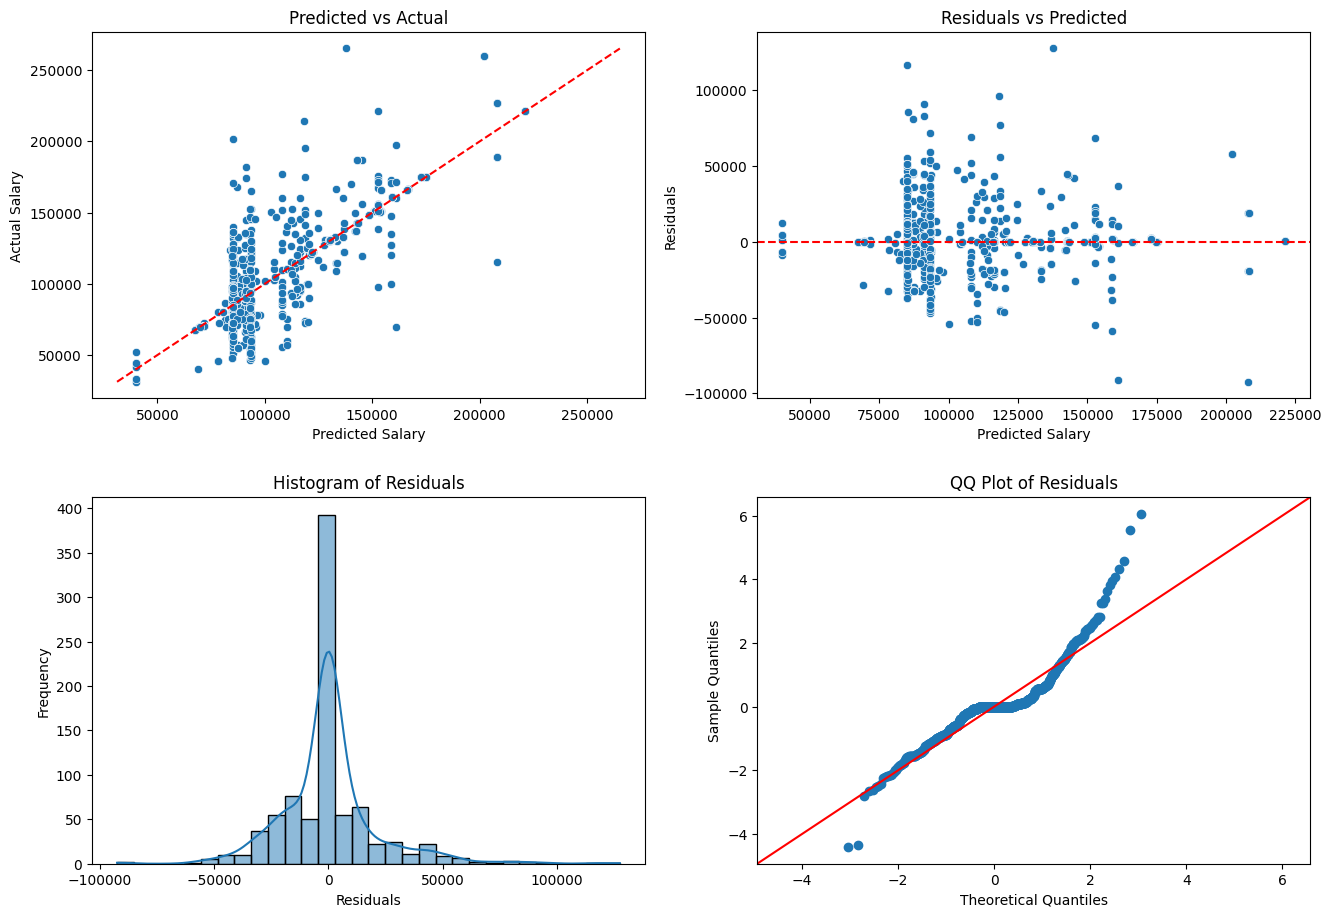

In [53]:
!pip install statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 创建 2x2 的图像网格
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plt.tight_layout(pad=5)

# Plot 1: Predicted vs Actual
sns.scatterplot(x='Predicted', y='Actual', data=predictions_df, ax=axs[0, 0])
axs[0, 0].plot(
    [predictions_df['Actual'].min(), predictions_df['Actual'].max()],
    [predictions_df['Actual'].min(), predictions_df['Actual'].max()],
    color='red', linestyle='--'
)
axs[0, 0].set_title('Predicted vs Actual')
axs[0, 0].set_xlabel('Predicted Salary')
axs[0, 0].set_ylabel('Actual Salary')

# Plot 2: Residuals vs Predicted
sns.scatterplot(x='Predicted', y='Residual', data=predictions_df, ax=axs[0, 1])
axs[0, 1].axhline(0, color='red', linestyle='--')
axs[0, 1].set_title('Residuals vs Predicted')
axs[0, 1].set_xlabel('Predicted Salary')
axs[0, 1].set_ylabel('Residuals')

# Plot 3: Histogram of Residuals
sns.histplot(predictions_df['Residual'], kde=True, ax=axs[1, 0], bins=30)
axs[1, 0].set_title('Histogram of Residuals')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: QQ Plot of Residuals
sm.qqplot(predictions_df['Residual'], line="45", fit=True, ax=axs[1, 1])
axs[1, 1].set_title('QQ Plot of Residuals')

plt.show()


Diagnostic Plot Summary
The diagnostic plots provide visual insights into the performance and assumptions of the linear regression model.

Predicted vs Actual Plot:
The scatterplot reveals a moderate positive relationship between predicted and actual salary values, but there is noticeable dispersion around the red reference line. This suggests that while the model is capturing some trends, it still struggles to fully capture the variability in salary, which aligns with the R² value around 0.26.

Residuals vs Predicted Plot:
The residuals appear to be scattered fairly symmetrically around the horizontal axis, indicating that the assumption of homoscedasticity (constant variance) is reasonably satisfied. However, there are signs of vertical clustering around certain predicted values, which may suggest the presence of categorical patterns or nonlinearities not captured by the model.

Histogram of Residuals:
The residuals are roughly normally distributed but slightly right-skewed. The peak and tails suggest the presence of outliers or high-leverage observations that deviate from the average behavior.

QQ Plot of Residuals:
The QQ plot indicates that residuals generally follow a normal distribution but exhibit noticeable deviation in the tails. This further supports the presence of outliers and suggests mild violations of the normality assumption.



The model performs decently in capturing trends but shows room for improvement. The residuals’ distribution and deviation from normality indicate that feature engineering or transformation (e.g., log-salary) might enhance model performance. Additionally, considering nonlinear models or regularization could help address variance and improve generalizability.

